# Sentiment Analysis on Food reviews
# Part 1

## Problem Statement

Many e-commerce prompt users to leave a review after purchasing an item from their website to understand a customer's experience. Reviews can affect another customers' decision on whether to purchase or not. Customers would judge the quality of an item based on previous customers' feedback. As part of the data scientist team in Consultancy of food product, we aim to classify the sentiment of reviews and to see if there are any potential roadblocks to customers' satisfaction.

## Background

Amazon.com Inc. is an American multinational technology company. It started out as an online bookseller and expanded its offerings to include music, clothings and a vast assortment of merchandise. It grown into an e-commerce behemoth. Currently, it is one of the prime site that shoppers would browse to buy anything from food to electronics.

With an increase in online shopping, giving reviews and ratings are how customers give feedback for businesses to understand the needs and wants of users. Using the wide range of food products that Amazon sell, we will conduct an analysis on its fine food dataset to categorize the sentiments of reviews.

https://www.kaggle.com/snap/amazon-fine-food-reviews

## Executive Summary

We started by cleaning the dataset, keeping the reviews of the latest year that the dataset has and to overcome the unbalanced dataset, we did abit of undersampling from the majority class.

We pre-processed our text by removing html tags, stopwords, non-letters, convert to lowercase and stem them, followed by splitting the dataset into train and test set.

We did some exploratory data analysis on train dataset and here are our findings:
- The average length of reviews were longer for negative sentiment.
- Customers found extreme ends of the review (Rating 1 and 5) to be the most helpful
- Food reviews were made up of text of people comparing it against a benchmark to express their likes/dislikes.

Next, we fit the dataset into logisitic regression, naive bayes, support vector classifier and long short term memory recurrent neural network to classify the reviews' sentiment.

Our machine learning and deep learning models outperformed VADER when determining a review sentiment, with deep learning being the winner.

Some topics in reviews that customers were dissatisfied about were Instant coffee and tea, bottled drinks, ingredient quality, pricey products, sugary snacks and pet food. Manufacturers could focus on improving their products, focuses on qualities that customers are concerned about and offering discounts to low quality products.

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|Id|int|reviews|asin, e.g. amazon.com/dp/(id)| 
|UserId|object|reviews|id of user| 
|ProfileName|object|reviews|name of user| 
|HelpfulnessNumerator|object|reviews|number of users who found review helpful| 
|HelpfulnessDenominator|int|reviews|total number of users who indicated if they found the review helpful or not| 
|Score|int|reviews|rating of product| 
|Time|int|reviews|time of review (Unix)| 
|Summary|object|reviews|review summary| 
|Text|object|reviews|review text|

## Contents
- [Import libraries](#Import-libraries)
- [Data cleaning](#Data-cleaning)
- [Pre-processing](#Pre-processing)
- [Train-test-split](#Train-test-split)
- [Exploratory data analysis](#Exploratory-data-analysis)
- [Benchmark model](#Benchmark-model)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from datetime import datetime

import re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Data cleaning

In [40]:
reviews = pd.read_csv('../datasets/Reviews.csv', parse_dates=['Time'])

In [41]:
reviews.shape

(568454, 10)

In [42]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [43]:
# rename columns
reviews.rename(columns={'Id': 'id', 
                        'ProductId': 'product_id', 
                        'UserId': 'user_id', 
                        'ProfileName': 'profile_name', 
                        'HelpfulnessNumerator': 'help_num', 
                        'HelpfulnessDenominator': 'help_denom',
                        'Score': 'score',
                        'Time': 'date',
                        'Summary': 'summary',
                        'Text': 'text'}, inplace=True)

I realised that there were duplicated reviews when analysing the product id. I realised for different product id and same count of reviews, they each contain the same exact reviews. It appears that the product were similar in terms of brand name but different packaging and name of product.

In [44]:
# only want unique reviews
reviews.drop_duplicates(['summary', 'text'], inplace=True)
reviews.reset_index(drop=True, inplace=True)

In [45]:
reviews.shape

(394970, 10)

#### We will keep only 100,000 reviews . We first drop reviews that were before 2012 (latest year in dataset) and then undersample the majority class (imbalance dataset).

In [53]:
# convert to datetime format
reviews['date'] = pd.to_datetime(reviews['date'], unit='s')
reviews['year'] = reviews['date'].dt.year

In [54]:
# count of reviews for years below 2012 -> unseen dataset
reviews[reviews['year'] < 2012]['id'].count()

255421

In [31]:
reviews.drop(reviews[reviews.year < 2012].index, inplace=True)
reviews.reset_index(drop=True, inplace=True)

# drop reviews of score 5 to lessen the unbalance dataset
reviews.drop(reviews[reviews['score']==5][:39549].index.to_list(), inplace=True)
reviews.reset_index(drop=True, inplace=True)

In [32]:
reviews.shape

(100000, 13)

#### Null values

In [12]:
# null values
reviews.isnull().sum()

id              0
product_id      0
user_id         0
profile_name    2
help_num        0
help_denom      0
score           0
date            0
summary         2
text            0
year            0
dtype: int64

In [13]:
reviews[reviews['summary'].isnull()]

,id,product_id,user_id,profile_name,help_num,help_denom,score,date,summary,text,year
26526,237566,B000ELGPAO,A15AMT9T9A1309,Film-Friend,1,1,3,2012-02-07,NaN,This is a cool system only problem is that the...,2012
60910,392530,B001H9XOEW,A22R17YPXEULEZ,Liz Wong,0,0,3,2012-04-16,NaN,I like the product and tried it before I pucha...,2012


In [14]:
# fill nan help_ratio to 0
reviews['summary'] = reviews['summary'].fillna('')
# merge summary and text into 1 column
reviews['merge'] = reviews['summary'] + str(' ') + reviews['text']

In [15]:
reviews[reviews['profile_name'].isnull()]

,id,product_id,user_id,profile_name,help_num,help_denom,score,date,summary,text,year,merge
71882,440826,B008LFAS08,AC0E8TXIYABB5,NaN,1,1,5,2012-10-17,The perfect grinder for dog and cat food!,this grinder is super easy to assemble and ope...,2012,The perfect grinder for dog and cat food! this...
87631,515437,B004S04X4W,A2H7605OSHVIQ5,NaN,0,0,5,2012-09-27,"Hormel Roast Beef Hash, 15-Ounce",I've been buying this in the grocery stores fr...,2012,"Hormel Roast Beef Hash, 15-Ounce I've been buy..."


Some people prefer to remain anonymous, hence profile name appears to be empty.

In [16]:
reviews['help_ratio'] = reviews['help_num']/reviews['help_denom']

In [17]:
# null values
reviews.isnull().sum()

id                  0
product_id          0
user_id             0
profile_name        2
help_num            0
help_denom          0
score               0
date                0
summary             0
text                0
year                0
merge               0
help_ratio      64374
dtype: int64

In [18]:
# fill nan help_ratio to 0
reviews['help_ratio'] = reviews['help_ratio'].fillna(0)

In [19]:
reviews

,id,product_id,user_id,profile_name,help_num,help_denom,score,date,summary,text,year,merge,help_ratio
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012,Not as Advertised Product arrived labeled as J...,0.0
1,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,2012-07-12,Nice Taffy,I got a wild hair for taffy and ordered this f...,2012,Nice Taffy I got a wild hair for taffy and ord...,0.0
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,2012-06-13,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,2012,My Cats Are Not Fans of the New Food My cats h...,1.0
3,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,2012-09-20,poor taste,I love eating them and they are good for watch...,2012,poor taste I love eating them and they are goo...,0.0
4,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,2012-03-25,Nasty No flavor,"The candy is just red , No flavor . Just plan...",2012,"Nasty No flavor The candy is just red , No fla...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,568447,B001EO7N10,A2P9W8T7NTLG2Z,Andy,0,0,2,2012-02-11,Mixed wrong,I had ordered some of these a few months back ...,2012,Mixed wrong I had ordered some of these a few ...,0.0
99996,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,2012-03-09,disappointed,I'm disappointed with the flavor. The chocolat...,2012,disappointed I'm disappointed with the flavor....,0.0
99997,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,2012-02-21,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012,Perfect for our maltipoo These stars are small...,1.0
99998,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,2012-03-13,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012,Favorite Training and reward treat These are t...,1.0


### Analysing each score

#### Score rating of 1

In [20]:
pd.set_option('display.max_colwidth', None)

In [21]:
reviews[reviews['score'] == 1][['merge']].head()

,merge
0,"Not as Advertised Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"My Cats Are Not Fans of the New Food My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat."
4,"Nasty No flavor The candy is just red , No flavor . Just plan and chewy . I would never buy them again"
10,"Warning! WARNING! -ALCOHOL SUGARS! Buyer Beware Please! This sweetener is not for everybody. Maltitol is an alcohol sugar and can be undigestible in the body. You will know a short time after consuming it if you are one of the unsuspecting many who cannot digest it by the extreme intestinal bloating and cramping and massive amounts of gas a person can experience. Nausea, diarrhea & headaches can also be experienced. I learned my lesson the hard way years ago when I fell in love with the sugar-free chocolates suzanne sommers used to sell. I thought I'd found sugar-free chocolate nirvana at first taste but the bliss was short lived when the terrible side effects of maltitol kicked in. The discomfort was unlike anything I had ever felt before. I blew up like a balloon and had very painful abdominal cramping. As the symptoms passed, this too was very unpleasant. Though hard for me to believe a low calorie sweetener could be the culprit, all symptoms were gone when I stopped eating the chocolate. My hunch it had something to do with the maltitol were unfortunately confirmed for me about a year later when I purchased some delicious sugar-free popcorn at my local market. The taste was amazing and while I was looking at the label wondering what could possibly make this yummy, new sugarfree treat taste so good, my heart sank when I followed the little asterisk next to sugarfree sweetener* down to the very bottom of the label and read ""maltitol"" in tiny little letters! Thank goodness I'd eaten only a little. I still ended up with all the same side-effects but for a much shorter duration. Some people can use maltitol to their heart's content but others, like me, can have a bad reaction to it. In case you're like me, ... it's not you ...it's the maltitol!"
12,"Bad I fed this to my Golden Retriever and he hated it. He wouldn't eat it, and when he did, it gave him terrible diarrhea. We will not be buying this again. It's also super expensive."


For score 1 review, they appear to be consistently negative

#### Score rating of 2

In [22]:
reviews[reviews['score'] == 2][['merge']].head()

,merge
3,poor taste I love eating them and they are good for watching TV and looking at movies! It is not too sweet. I like to transfer them to a zip lock baggie so they stay fresh so I can take my time eating them.
9,"Taste is not so good. I purchased the Mango flavor, and to me it doesn't take like Mango at all. There is no hint of sweetness, and unfortunately there is a hint or aftertaste almost like licorice. I've been consuming various sports nutrition products for decades, so I'm familiar and have come to like the taste of the most of the products I've tried. The mango flavor is one of the least appealing I've tasted. It's not terrible, but it's bad enough that I notice the bad taste every sip I take."
27,"Altoids Smalls Even with small containers, they don't fill them up. These little tins are less than half filled and at the price charged it seems a rip-off. Is there some exotic ingredient as costly as gold contained in those tiny squares? Or how about the cereal ploy, they were filled at the factory but settled in transport.<br />Can manufacturers be honest in their dealings?"
36,"Disappointed! This product has a strong after-taste of Crayola crayons!<br /><br />I am in the process of trying different brands of coconut oils for cooking purposes. Upon opening the plastic container, the aroma of crayons immediately fills the room, and this flavor permeates the food that is cooked in it.<br /><br />I suspect the source of the problem is the plastic used in the plastic container as I have not experienced this with any of the other brands purchased.<br /><br />To date, my favorite coconut oil is distributed by Barleans. The flavor is fantastic. However, they do not supply a gallon-sized tub,and Dr. Mercola has the best product in that size category."
83,"City Steam, not much steam in this brew. My husband and I were very disappointed in this coffee, very weak, watery cup of coffee. A definite waste of $13.00."


For score 2 review, they appear to be negative, with some contradicting reviews. For example, in index 3, although the summary was 'poor taste', the reviewer wrote good feedback about the product. However, other reviews are negative still

#### Score rating of 3

In [23]:
reviews[reviews['score'] == 3][['merge']].head()

,merge
7,Same stuff This is the same stuff you can buy at the big box stores. There is nothing healthy about it. It is just carbs and sugars. Save your money and get something that at least has some taste.
11,"Order only in cold weather The taste was great, but the berries had melted. May order again in winter. If you order in cold weather you should enjoy flavor."
15,"It burns! I LOVE spicy ramen, but for whatever reasons this thing burns my stomach badly and the burning sensation doesn't go away for like 3 hours! Not sure if that is healthy or not .... and you can buy this at Walmart for $0.28, way cheaper than Amazon."
17,Ehhh... These remind me of dog treats I made once using pumpkin and cinnamon. They're kind of bland and not my favorite Back To Nature product. But my finace really loves them so that's where the three stars come from.
19,"Not the greatest tasting.. I have always purchased Star-Kist tuna but thought I would try this brand for a change of pace. The taste of the tuna was not pleasant, too much basil and other spices for me."


For score 3 reviews, they appear to be negative as well as feedback for improvements.

#### Score rating of 4

In [24]:
reviews[reviews['score'] == 4][['merge']].head()

,merge
1,"Nice Taffy I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat."
5,Great Bargain for the Price I was so glad Amazon carried these batteries. I have a hard time finding them elsewhere because they are such a unique size. I need them for my garage door opener.<br />Great deal for the price.
6,"GOOD WAY TO START THE DAY.... I WAS VISITING MY FRIEND NATE THE OTHER MORNING FOR COFFEE , HE CAME OUT OF HIS STORAGE ROOM WITH ( A PACKET OF McCANNS INSTANT IRISH OATMEAL .) HE SUGGESTED THAT I TRY IT FOR MY OWN USE ,IN MY STASH . SOMETIMES NATE DOSE NOT GIVE YOU A CHANCE TO SAY NO , SO I ENDED UP TRYING THE APPLE AND CINN . FOUND IT TO BE VERY TASTEFULL WHEN MADE WITH WATER OR POWDERED MILK . IT GOES GOOD WITH O.J. AND COFFEE AND A SLICE OF TOAST AND YOUR READY TO TAKE ON THE WORLD...OR THE DAY AT LEAST.. JERRY REITH..."
8,"You'll go nuts over Ass-Kickin' Peanuts. This wasn't in stock the last time I looked. I had to go to the Vermont Country Store in Weston to find it along with a jaw harp, Cranberry Horseradish Sauce, Fartless Black Bean Salsa, Apple Cider Jelly, Newton's Cradle Art in Motion and the staple Vermont Maple Syrup.<br /><br />Back to the Ass Kickin Peanuts. They are hot. They will activate the perspiration glands behind your ears and under your arms. It requires a beverage as advertised, a glass of very cold milk, and a box of Kleenex since it will make your nose run. They look like ordinary peanuts which is already giving me ideas for work. I suspect that some people have been hitting my goodies in my absence, especially my colleague Greg. I'm going to take this to work at earliest opportunity and empty the contents of this can into an ordinary Planters Peanuts can, and then see whose crying or whose nose is running when I return.<br /><br />The can should be shaken to ensure the spices are evenly distributed. It is important to wash your hands after consumption and not touch the eyes.<br /><br />You'll go nuts over these Ass-Kickin' Peanuts.<br /><br />P.S. I'm not sharing the peanuts, not deliberately, and I'll probably give Greg the jaw harp for Christmas. He'll be so insulted."
13,"TART! The crust on these tarts are perfect. My husband loves these, but I'm not so crazy about them. They are just too sour/tart for my taste. I'll eat the crust and hubby takes my filling. My kids think they're great, so maybe it's just me."


For score 4 reviews, most appear to be postive.

#### Score rating of 5

In [25]:
reviews[reviews['score'] == 5][['merge']].head()

,merge
24623,good stuff This works very well to thicken gravies. I have never had lumps with this product. I love it and use it often.
24628,"Love it People knocking this stuff are crazy.<br />This is seriously one of the best ""cut corner"" ingredients out there.<br />We make peanut sauces for thai cooking night. Spread on bananas for breakfast. Or even just dip pretzels or crackers in it.<br />Love the taste. It's almost sweeter than the real thing. Obviously, it's not exactly the same consistency of real peanut butter, but for 1/5 of the fat per serving, it's worth checking out.<br /><br />give it a try. good stuff!"
24629,"Totally Worth It! I have a husband and three little boys - all of whom would eat brown gravy with every meal. However, my family only prescribes to McCormick's brown gravy, so I was spending *lots* of money on individual packs... until I found this 21 oz. container. This is definitely a staple in my household and I hope they never stop selling this product... unless, of course, they start producing an even bigger one."
24630,"Glad I gave it a try. This is a pleasant tasting product, especially for an instant gravy. I also use it to thicken certain recipes with great results."
24631,gravy love gravy on my bread or corn bread. tastes great with a variety of food. i do a lot of sunday afternoon cookouts and this stuff comes in handy on my mashed potatoes. easy to fix. no time at all.


For score 5 reviews, they appear to be postive sentiment.

In [26]:
reviews['score'].value_counts(normalize=True)

5    0.46529
4    0.19957
1    0.14557
3    0.11004
2    0.07953
Name: score, dtype: float64

To predict if a review is good or bad, we will binarize the score. As we are interested in bad reviews, 1 will indicate bad reviews while 0 indicates good reviews<br>
1: score 1 to 3<br>
0: score 4 to 5

In [27]:
reviews['label'] = reviews['score'].map(lambda x: 1 if x <= 3 else 0)

In [28]:
reviews['label'].value_counts(normalize=True)

0    0.66486
1    0.33514
Name: label, dtype: float64

## Pre-processing
We will transform the text that we are interested in to be able to fit into the model easily.


In [29]:
# NLTK english stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Remove html tags, non-letters, stopwords, change to lower case and stem words.

In [30]:
# The input is a single string (a raw food review), output is a single string (a preprocessed food review)
def review_stem(raw_review):
    """Function to preprocess original text into string of words"""
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Stopwords
    stops = set(stopwords.words('english'))
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Instantiate stemmer.
    stemmer = PorterStemmer()
    
    # 7. Stem words.
    stemmed_words = [stemmer.stem(i) for i in meaningful_words]
    
    # 8. Join the words back into one string separated by space, and return the result.
    return(" ".join(stemmed_words))

### Remove html tags, non-letters and change to lower case

In [57]:
def review_deeplearning(raw_review):
    """Function to preprocess original text into string of words"""
    
    review_text = BeautifulSoup(raw_review).get_text()
    
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    words = letters_only.lower().split()
    
    meaningful_words = [w for w in words]

    return(" ".join(meaningful_words))

In [32]:
# Maintain sequences
#def review_deeplearning(raw_review):
    #"""Function to preprocess original text into string of words"""
    
    # 1. Remove HTML.
    #review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Convert to lower case, split into individual words.
    #words = review_text.lower().split()

    # 3. Join the words back into one string separated by space, and return the result.
    #return(" ".join(words))

In [33]:
# used for deep learning and topic modeling
reviews['merge_dl'] = reviews['merge'].map(review_deeplearning)

In [34]:
# used for machine learning
reviews['merge_processed'] = reviews['merge'].map(review_stem)

In [35]:
reviews.head()

,id,product_id,user_id,profile_name,help_num,help_denom,score,date,summary,text,year,merge,help_ratio,label,merge_dl,merge_processed
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",2012,"Not as Advertised Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",0.0,1,not as advertised product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo,advertis product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo
1,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,2012-07-12,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.",2012,"Nice Taffy I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.",0.0,0,nice taffy i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was a bit too much red black licorice flavored pieces just not my particular favorites between me my kids and my husband this lasted only two weeks i would recommend this brand of taffy it was a delightful treat,nice taffi got wild hair taffi order five pound bag taffi enjoy mani flavor watermelon root beer melon peppermint grape etc complaint bit much red black licoric flavor piec particular favorit kid husband last two week would recommend brand taffi delight treat
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,2012-06-13,My Cats Are Not Fans of the New Food,"My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat.",2012,"My Cats Are Not Fans of the New Food My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat.",1.0,1,my cats are not fans of the new food my cats have been happily eating felidae platinum for more than two years i just got a new bag and the shape of the food is different they tried the new food when i first put it in their bowls and now the bowls sit full and the kitties will not touch the food i ve noticed similar reviews related to formula changes in the past unfortunately i now need to find a new food that my cats will eat,cat fan new food cat happili eat felida platinum two year got new bag shape f

### Remove reviews that do not contain text

In [36]:
# count length of words in each review
reviews['len_mp'] = reviews['merge_processed'].str.split().apply(len)

# review with 0 text
reviews[reviews['len_mp']==0]

,id,product_id,user_id,profile_name,help_num,help_denom,score,date,summary,text,year,merge,help_ratio,label,merge_dl,merge_processed,len_mp
25751,233939,B003E6COMO,A2ZE58VIDDCMR7,inna,1,2,5,2012-10-12,&#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;,"&#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1079;&#1072;&#1082;&#1072;&#1079;&#1072;&#1090;&#1100; &#1101;&#1090;&#1080; &#1078;&#1077;&#1083;&#1072;&#1090;&#1080;&#1085;&#1082;&#1080;, &#1090;.&#1082;. &#1076;&#1086;&#1095;&#1082;&#1072; &#1087;&#1086;&#1096;&#1083;&#1072; &#1074; &#1096;&#1082;&#1086;&#1083;&#1091; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090; &#1089;&#1083;&#1072;&#1076;&#1086;&#1089;&#1090;&#1080;. &#1054;&#1095;&#1077;&#1085;&#1100; &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;. &#1050;&#1072;&#1082; &#1088;&#1072;&#1079; &#1089;&#1090;&#1086;&#1083;&#1100;&#1082;&#1086; &#1082;&#1086;&#1085;&#1092;&#1077;&#1090;, &#1082;&#1072;&#1082; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090;&#1089;&#1103;, &#1095;&#1090;&#1086;&#1073;&#1099; &#1089;&#1100;&#1077;&#1089;&#1090;&#1100; &#1080;&#1093; &#1079;&#1072; &#1087;&#1077;&#1088;&#1077;&#1084;&#1077;&#1085;&#1091;.",2012,"&#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072; &#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1079;&#1072;&#1082;&#1072;&#1079;&#1072;&#1090;&#1100; &#1101;&#1090;&#1080; &#1078;&#1077;&#1083;&#1072;&#1090;&#1080;&#1085;&#1082;&#1080;, &#1090;.&#1082;. &#1076;&#1086;&#1095;&#1082;&#1072; &#1087;&#1086;&#1096;&#1083;&#1072; &#1074; &#1096;&#1082;&#1086;&#1083;&#1091; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090; &#1089;&#1083;&#1072;&#1076;&#1086;&#1089;&#1090;&#1080;. &#1054;&#1095;&#1077;&#1085;&#1100; &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;. &#1050;&#1072;&#1082; &#1088;&#1072;&#1079; &#1089;&#1090;&#1086;&#1083;&#1100;&#1082;&#1086; &#1082;&#1086;&#1085;&#1092;&#1077;&#1090;, &#1082;&#1072;&#1082; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090;&#1089;&#1103;, &#1095;&#1090;&#1086;&#1073;&#1099; &#1089;&#1100;&#1077;&#1089;&#1090;&#1100; &#1080;&#1093; &#1079;&#1072; &#1087;&#1077;&#1088;&#1077;&#1084;&#1077;&#1085;&#1091;.",0.5,0,,,0


In [37]:
reviews.drop([25751], inplace=True)
reviews.reset_index(drop=True, inplace=True)

In [38]:
# count length of words in each review
reviews['len_dl'] = reviews['merge_dl'].str.split().apply(len)

# review with 0 text
reviews[reviews['len_dl']==0]

,id,product_id,user_id,profile_name,help_num,help_denom,score,date,summary,text,year,merge,help_ratio,label,merge_dl,merge_processed,len_mp,len_dl


In [39]:
reviews[['label','merge_dl']].to_csv('../datasets/dl_reviews.csv', index=False)

## Train test split
We will split our dataset into train and test set

In [41]:
X = reviews[[col for col in reviews.columns if col != 'label']]
y = reviews['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=40)

train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [42]:
train.shape

(79999, 18)

In [43]:
train['label'].value_counts(normalize=True)

0    0.664858
1    0.335142
Name: label, dtype: float64

In [44]:
test['label'].value_counts(normalize=True)

0    0.66485
1    0.33515
Name: label, dtype: float64

**Distribution of labels are preserved.**

## Exploratory data analysis
We will do exploratory data analysis on train dataset.

### Average number of words in reviews

#### Stemmed and no stopwords tokens

In [45]:
# average number of words in each review
np.mean(train['len_mp'])

44.21357766972087

In [46]:
# average number of words in each positive and negative review
train.groupby('label')[['len_mp']].mean()

,len_mp
label,
0,42.698428
1,47.219350


#### Non stemmed and with stopwords tokens

In [47]:
# average number of words in each review
np.mean(reviews['len_dl'])

89.39257392573926

In [48]:
# average number of words in each positive and negative review
reviews.groupby('label')[['len_dl']].mean()

,len_dl
label,
0,85.725968
1,96.666378


#### Bar plot of helpfulness ratio for individual ratings

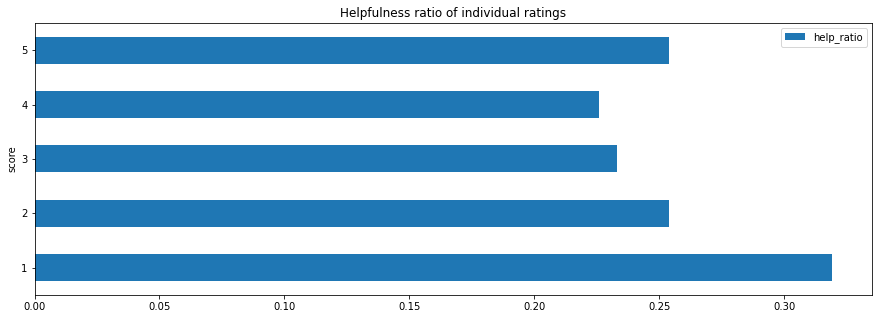

In [49]:
train.groupby('score')[['help_ratio']].mean().plot.barh(figsize=(15,5), title='Helpfulness ratio of individual ratings');

Helpfulness ratio for lowest rating is the highest, followed by the highest rating. This shows that people could relate more towards the extreme ends of the ratings. This might be because reviewers tend to write more expressive reviews when it is on the extreme ends as they have to justify why they give a really bad or really good review.

### Most frequent words

#### Uni-gram

##### Negative sentiment

In [48]:
A = train[train['label']==1]['merge_processed']

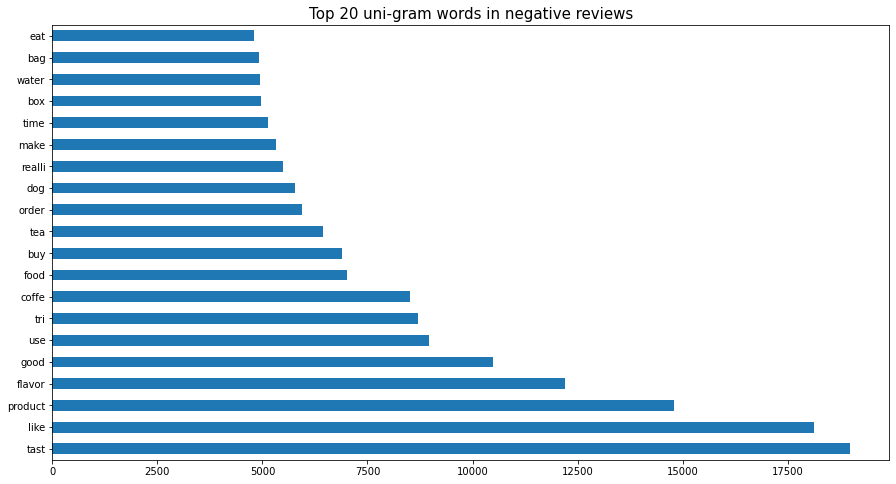

In [49]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,1))
df = pd.DataFrame(cvec.fit_transform(A).toarray(), columns=cvec.get_feature_names())
df.sum(axis=0).sort_values(ascending=False).head(20).plot.barh(figsize=(15,8))
plt.title('Top 20 uni-gram words in negative reviews', fontsize=15);

Top words in negative reviews are 'tast', 'like', 'product'. They revolve around talking about the taste of products. Like may occur because 'not', 'no', 'didn't', 'doesn't' were removed as stopwords. Hence, the meaning of the sentence might change.

In [50]:
train[(train['label']==1) & (train['merge_processed'].str.contains("tast"))][['merge_processed', 'label']].head()

,merge_processed,label
4417,bland tast bought tri lower fat altern peanut found tast bland chalki go organ product pre portion one ounc bag conveni carri purs bag high protein low fat realli tast sea salt flavor though,1
15646,tast like salti tofu basic vienna sausag sinc childhood even occasion peopl hous much less flavor much saltier rememb bad basic tasteless much like tofu would suggest anyon think buy see compani market low sodium version pink slime scare bit exagger detail still unnerv howev heard mani time famili friend associ nativ american chines doctor etc health consum muscl tissu anim gave thought pink slime contain everi type anim part notabl contain highli benefici part normal eat u tendon ligament actual healthi item featur cuisin number cultur unlik sit nice bowl chines beef tendon think could even chew price product ethnic market expens case cheapo littl hotdog offer thing mayb warrant reconsider line thought anyway someth consid suffer ailment arthriti bone joint issu though serious look low salt one want tri salti sinc got lot order abl use rather like salti condiment ad dish bean,1
16641,bewar plastic jar purchas item local health food store glass jar fell love flavor place amazon order bother looka whether glass jar fault order came today andyou guess manna plastic jar product opinion tast asgood coconut manna glass jar will go back health foodstor pay littl bit plastic interf solov product,1
2080,tast like chemic shih tzu pekinges would eat ye tast tast like chemic guess expect joint supplement shih tzu pekinges would eat,1
19228,sour expect candi initi weird chemic tast thought would realli sour right bat took minut get sour core bad expect packag consist small box box contain dozen lemonhead make conveni carri around,1


In [83]:
# an example
train.loc[19228]['merge']

'Not as sour as I expected These candies have an initial weird chemical taste. I thought they would be really sour right off the bat, but it took a few minutes to get to the sour core. Not bad, just not what I was expecting. The packaging consists of 24 small boxes, each box containing about a dozen lemonheads. This makes it convenient to carry around'

Customers used 'tast' to describe how the product taste like.

In [51]:
train[(train['label']==1) & (train['merge_processed'].str.contains("like"))][['merge_processed', 'label']].head()

,merge_processed,label
15646,tast like salti tofu basic vienna sausag sinc childhood even occasion peopl hous much less flavor much saltier rememb bad basic tasteless much like tofu would suggest anyon think buy see compani market low sodium version pink slime scare bit exagger detail still unnerv howev heard mani time famili friend associ nativ american chines doctor etc health consum muscl tissu anim gave thought pink slime contain everi type anim part notabl contain highli benefici part normal eat u tendon ligament actual healthi item featur cuisin number cultur unlik sit nice bowl chines beef tendon think could even chew price product ethnic market expens case cheapo littl hotdog offer thing mayb warrant reconsider line thought anyway someth consid suffer ailment arthriti bone joint issu though serious look low salt one want tri salti sinc got lot order abl use rather like salti condiment ad dish bean,1
86663,like side dish add chees make great dip someon need substanc food consid entre like side dish flavor okay fan store bought microwav indian dish ad slice kraft american chees turn dip tostito scoop bad,1
20906,better option honest want like formula ga spit issu enfamil newborn pediatrician recommend week old son read ingredi saw first one corn syrup balk purchas three pack babi organ amazon hope would work us made babi terribl constip bought target brand gentl formula suppos compar still get spit up switch mix enfamil newborn enfamil ar back horribl scream ga issu final reluctantli admit four thing tri best us bought brand name target brand smell like malt mix mix well realli differ enfamil target smell color enfamil mix well either give son horribl green swamp poop runni explos appar normal gentl formula yuk son better suspect lactos sensit realli cut ga help pass scream pain day sleep well eat without pain would like eat someth make diaper nasti worth plu use cloth diaper poop explod diaper onto cloth make interest diaper chang still complet settl two month suppli wish could find someth would agre without gross diaper less ideal ingredi updat switch babi lactorelief saw huge improv reflux symptom feed stool improv drastic new babi come believ reflux,1
2080,tast like chemic shih tzu pekinges would eat ye tast tast like chemic guess expect joint supplement shih tzu pekinges would eat,1
13747,salti product salti tast strongli recommend like light flavor buy product,1


In [81]:
# an example
train.loc[13747]['merge']

'Too salty! This product is too salty for my taste.<br />I strongly do not recommend it to those who like light flavor.<br />I will not buy this product again...'

'Like' was used to describe whether or not one would like the item.

In [52]:
train[(train['label']==1) & (train['merge_processed'].str.contains("product"))][['merge_processed', 'label']].head()

,merge_processed,label
4417,bland tast bought tri lower fat altern peanut found tast bland chalki go organ product pre portion one ounc bag conveni carri purs bag high protein low fat realli tast sea salt flavor though,1
13557,contain palm fruit oil pleas buy product pure back natur good good environ product contain palm fruit oil cut forest could spell complet demis orangutan habitat palm fruit oil use soap cosmet lot thing thought high end peanut butter amazon need put inform product list least peopl know get,1
15646,tast like salti tofu basic vienna sausag sinc childhood even occasion peopl hous much less flavor much saltier rememb bad basic tasteless much like tofu would suggest anyon think buy see compani market low sodium version pink slime scare bit exagger detail still unnerv howev heard mani time famili friend associ nativ american chines doctor etc health consum muscl tissu anim gave thought pink slime contain everi type anim part notabl contain highli benefici part normal eat u tendon ligament actual healthi item featur cuisin number cultur unlik sit nice bowl chines beef tendon think could even chew price product ethnic market expens case cheapo littl hotdog offer thing mayb warrant reconsider line thought anyway someth consid suffer ailment arthriti bone joint issu though serious look low salt one want tri salti sinc got lot order abl use rather like salti condiment ad dish bean,1
16641,bewar plastic jar purchas item local health food store glass jar fell love flavor place amazon order bother looka whether glass jar fault order came today andyou guess manna plastic jar product opinion tast asgood coconut manna glass jar will go back health foodstor pay littl bit plastic interf solov product,1
69853,unit price list incorrect review product per se warn list say come cent ounc regular price cent ounc subscrib save realli ounc box ounc number complet wrong low subscrib save come cent ounc,1


In [78]:
# an example
train.loc[4417]['merge']

"Bland tasting I bought these to try as a lower fat alternative to peanuts. I found the taste to be bland and chalky. What it does have going for it: it's an organic product, and the pre-portioned one ounce bags are convenient to carry in a purse or bag. It's high in protein and low in fat. I couldn't really taste the sea salt flavor though."

'Product' is referring to food items that they bought.

##### Positive sentiment

In [53]:
B = train[train['label']==0]['merge_processed']

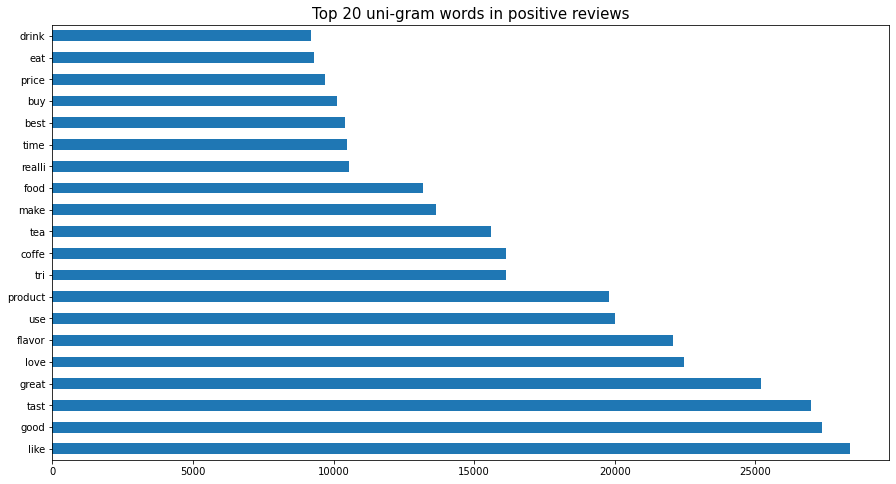

In [54]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,1))
df = pd.DataFrame(cvec.fit_transform(B).toarray(), columns=cvec.get_feature_names())
df.sum(axis=0).sort_values(ascending=False).head(20).plot.barh(figsize=(15,8))
plt.title('Top 20 uni-gram words in positive reviews', fontsize=15);

Top positive sentiment words are 'like', 'good', tast'.

'like' and 'tast' appeared in the top frequently occuring words for negative sentiment as well, because reviews are about food.

In [55]:
train[(train['label']==0) & (train['merge_processed'].str.contains("like"))][['merge_processed', 'label']].head()

,merge_processed,label
81364,best cat food avail ton research cat food would best option cat lose cat liver kidney failur think happen due taint pet food want better surviv cat main problem good brand can plant poor qualiti product merrick facil use human grade food ingredi highli recommend varieti pack start cat food patient switch cat similar take child eaten noth fast food transit healthi meal sure break solid food thoroughli mix well broth still uninterest tri mix small amount regular food took day realli got tast want eat old food still taper gradual go favorit flavor old food popular flavor merrick cowboy cuisin new england boil recommend start flavor awar may see cook blood vessel one beef look almost like pasta good thing show food made whole cut beef meat sludg,0
35639,happi custom spaghetti gf favorit reason price boot throw back white pasta grew gave four star b c love like book thu far substitut textur flavor whole wheat pasta,0
45303,expect gaham cracker love graham cracker love crisp way crumbl mouth love subtl sweet hint spice graham cracker deliv thing exactli expect graham cracker noth noth less smaller size stack much conveni snack use someth like more take lot effort break tradit graham cracker half avoid annoy problem break evenli crumbl process would happi order,0
79863,great tast low fat peanut butter pb stapl kitchen also keep contain work make quick easi snack powder peanut butter peanut fat remov plu small amount sugar salt flavor amount sugar per tablespoon serv gram equival teaspoon dietitian recommend patient need follow low fat diet want give peanut butter favorit way eat appl slice although patient tell like dip fresh fruit directli powder amazon seem best price item,0
69338,love vinegar wish came bigger bottl use vinegar salad soup sandwhich fish replac splash wine saute veget perfect complement like regular vinegar tart sour mild pleasant flavor sour sweet either also make great condiment slice strawberri coupl tablespoon bowl slice strawberri let sit min serv delici,0


In [77]:
# an example
train.loc[35639]['merge']

"happy customer this spaghetti is our GF favorite, at a reasonable price to boot.  It is a throw back to the white pasta i grew up on.<br /><br />i only gave it four stars, b/c we don't love it, but we do like it.  in our book, thus far, there is no substitute for the texture and flavor of whole wheat pasta."

'Like' was used to show that customer like the product

In [56]:
train[(train['label']==0) & (train['merge_processed'].str.contains("good"))][['merge_processed', 'label']].head()

,merge_processed,label
5920,pretti good thumb banana nut bread good love banana bread soft bake bar alli,0
15683,tasti tasti flavor one could drink everyday honey flavor make littl sweet palett dessert coffe work wonder everyday repeat use good special treat flavor,0
43732,good cat ib order cat ib seem help put small amount pumpkin pure,0
81364,best cat food avail ton research cat food would best option cat lose cat liver kidney failur think happen due taint pet food want better surviv cat main problem good brand can plant poor qualiti product merrick facil use human grade food ingredi highli recommend varieti pack start cat food patient switch cat similar take child eaten noth fast food transit healthi meal sure break solid food thoroughli mix well broth still uninterest tri mix small amount regular food took day realli got tast want eat old food still taper gradual go favorit flavor old food popular flavor merrick cowboy cuisin new england boil recommend start flavor awar may see cook blood vessel one beef look almost like pasta good thing show food made whole cut beef meat sludg,0
36532,happi custom love em set discount price subscript three cheer good sens organ raw almond edit went order extra bunch almond subscript rate stock second time sever month,0


In [76]:
# an example
train.loc[36532]['merge']

"Any very happy customer :) Love 'em. Have them set up on the discounted price subscription now.  Three cheers for Good Sense Organic Raw Almonds :)<br /><br />Edit - Went to order an extra bunch of almonds under the subscription rate and they are out of stock for a second time in several months."

'Good' was used to compliment the product.

In [57]:
train[(train['label']==0) & (train['merge_processed'].str.contains("tast"))][['merge_processed', 'label']].head()

,merge_processed,label
15683,tasti tasti flavor one could drink everyday honey flavor make littl sweet palett dessert coffe work wonder everyday repeat use good special treat flavor,0
34179,best tast tast excel mix berri almond milk forget ice also tri peach cream lost pound powder shake,0
36189,know star rate order easi sprouter yeah babi day soak day quick rins effort easi sprouter much fresher store bought save money great shelf life want larg varieti differ seed spout chase fresh veggi winter tasti healthi cheap easi noth wrong pictur,0
81364,best cat food avail ton research cat food would best option cat lose cat liver kidney failur think happen due taint pet food want better surviv cat main problem good brand can plant poor qualiti product merrick facil use human grade food ingredi highli recommend varieti pack start cat food patient switch cat similar take child eaten noth fast food transit healthi meal sure break solid food thoroughli mix well broth still uninterest tri mix small amount regular food took day realli got tast want eat old food still taper gradual go favorit flavor old food popular flavor merrick cowboy cuisin new england boil recommend start flavor awar may see cook blood vessel one beef look almost like pasta good thing show food made whole cut beef meat sludg,0
87593,fun special treat pup alway get special treat leav home short period time purchas purpos arriv quickli pup love look forward bye bye treat keep busi clean teeth seem tast good complaint mani one bag think would buy come zip lock bag conveni,0


In [75]:
# an example
train.loc[34179]['merge']

"best taste Taste excellent with mix berries and almond milk don't forget the ice, also try the peaches and cream I've lost 20 pounds with this powder shake."

'Tast' was used together with a postive/negative word. Hence, it appeared in both positive and negative sentiment.

#### Bi-gram

##### Negative sentiment

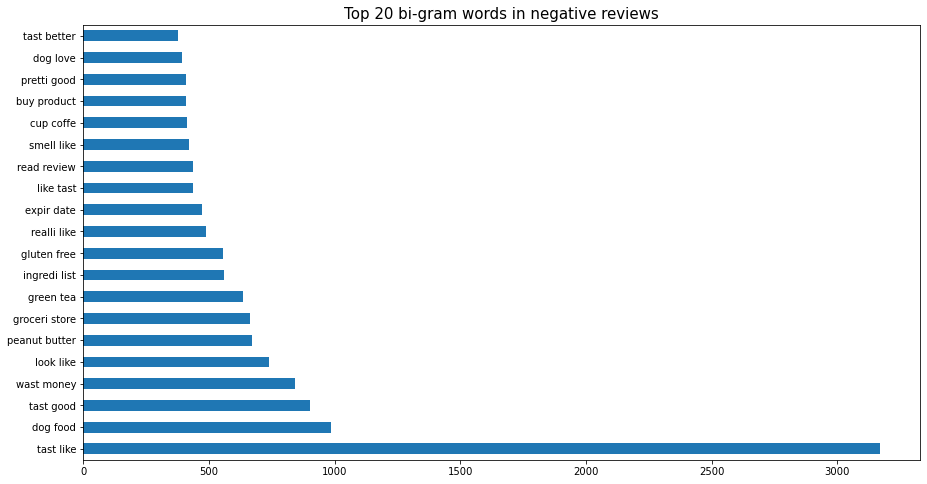

In [58]:
cvec = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=2000)
df = pd.DataFrame(cvec.fit_transform(A).toarray(), columns=cvec.get_feature_names())
df.sum(axis=0).sort_values(ascending=False).head(20).plot.barh(figsize=(15,8))
plt.title('Top 20 bi-gram words in negative reviews', fontsize=15);

Top negative sentiment words are 'tast like', 'dog food' and 'tast good'.

In [59]:
train[(train['label']==1) & (train['merge_processed'].str.contains("tast like"))][['merge_processed', 'label']].head()

,merge_processed,label
15646,tast like salti tofu basic vienna sausag sinc childhood even occasion peopl hous much less flavor much saltier rememb bad basic tasteless much like tofu would suggest anyon think buy see compani market low sodium version pink slime scare bit exagger detail still unnerv howev heard mani time famili friend associ nativ american chines doctor etc health consum muscl tissu anim gave thought pink slime contain everi type anim part notabl contain highli benefici part normal eat u tendon ligament actual healthi item featur cuisin number cultur unlik sit nice bowl chines beef tendon think could even chew price product ethnic market expens case cheapo littl hotdog offer thing mayb warrant reconsider line thought anyway someth consid suffer ailment arthriti bone joint issu though serious look low salt one want tri salti sinc got lot order abl use rather like salti condiment ad dish bean,1
2080,tast like chemic shih tzu pekinges would eat ye tast tast like chemic guess expect joint supplement shih tzu pekinges would eat,1
7068,festiv realli excit tassimo get mocha line coffe love chocol mix peppermint realli high hope blend tast like ga x mix coffe like ga x stay rest day festiv holiday coffe must say regular mocha delight note way cheaper tassimo com thu feel guilti throw,1
82112,chang recip tate horribl avid fan cooki year famili went dozen box month use take function donat give gift dark rich wholesom deep tast experi may find shelf normal store week back took home open surpris find insid contain differ use three row ran short end box two row ran long end box big deal chang took cooki pop mouth expect dark rich wholesom experi cooki tast bad almost threw sickli sweet tast like combin oreo health food bar move middl ground like health food bar like oreo sweet tast like oreo like health food bar tast aw sad chang formul best cooki market turn mani peopl chang recip none us ever buy worst cooki ever tast,1
59154,way overpr whoa research notic one box south beach diet bar fiber granola bar mouth cost order amazon prime realiz everyon factor anoth coupl buck ship ridicul price sure much box cost store consider less would hope daresay unlik price worth product anyon could use good diet bar problem diet bar name diet bar suppos tast great otherwis danger eat whole box kind diet instead usual tast like mix cardboard well cardboard south beach diet bar granola bar aw take delici look beast packag truth real product much flatter tast well tast exactli would think chocol diet bar would tast like unfair bash diet bar base tast admit diet bar suppos tast good imag packag realli got hope effect bar effect enough ate one morn eat till later even realli prais diet bar pretti hectic schedul mayb notic hunger much guess could eat granola bar get better tast cheaper price level hungri take diet diet bar serious might bar realli anyth separ snack bar south beach name hey know,1


In [74]:
# an example
train.loc[2080]['merge']

"Tastes like chemicals...my Shih tzu & Pekingese would not eat them. Yes, I tasted them - they taste like chemicals but I guess that's what you should expect from a joint supplement.  My Shih tzu & Pekingese would not eat them."

'Tast like' was used to compare it to another object.

In [60]:
train[(train['label']==1) & (train['merge_processed'].str.contains("dog food"))][['merge_processed', 'label']].head()

,merge_processed,label
27223,updat dog like agre sensit stomach updat dog nervou tummi never know upset blue buffalo good qualiti food absolut agre also tri beaver dam tri variou food made blend food one agre well system ye top meat ingredi product meal corn consid poor qualiti thrive grow food go figur like reseal bag rememb seal howev cat crawl insid bag found mani minut hour complet insid munch coma bliss harm done either recommend howev cat mine stray glutton astonish capac nice soft kibbl dog food aroma fresh veget open bag realli varieti ingredi nourish dog howev first three ingredi concern corn chicken product meal corn gluten meal dog sensit corn chicken product meal ground chicken carcas offal innard bone attach meat less digest chicken meat exampl feed dog mix offal gizzard liver heart ground mix chicken thigh corn debat ingredi cheap chicken product meal possibl allergen certainli less digest rice dog digest may ok though feel corn involv variou dog diseas like diabet obes corn help kibbl process starchi bottom line top three ingredi cheap ingredi dog may benefit dog get allergi skin irrit corn dog enjoy make dog mash brown rice turkey thigh green bean supplement eat love groceri store dog food bad ingredi ground yellow corn chicken product meal corn gluten meal whole wheat flour beef tallow preserv mix tocopherol sourc vitamin e rice flour beef soy flour sugar sorbitol tricalcium phosphat water anim digest salt phosphor acid potassium chlorid dicalcium phosphat sorbic acid preserv l lysin monohydrochlorid dri pea dri carrot calcium carbon calcium propion preserv cholin chlorid vitamin supplement e b,1
27320,dog like first ingredi corn dog bag consid two dog weigh lb lot dog open bag easi quick snip scissor close bag especi nice zip lock zipper type close kind littl plastic tab let slide close nice bag plastic dog food stay nice fresh pooch bag anoth nice point pour cup dog gobbl look hmm usual dog food give pain look shuffl bowl suppos attitud check bag wonder gung ho main ingredi corn thrown bunch stuff basic made doggi junk food mean live stuff go keep healthi someth say meat first ingredi usual feed costco brand dog food way highli rate among rate dog food laugh keep famili canin give hairi eyebal mix bene usual kibbl cours pick bene bit leav rest behind know fur kid never know good heck eat cat poop litter box let think stick usual healthi yet tasti costco dog food might throw someben littl treat like movi night someth,1
64018,much flavor use person cook realli bland tast slight flavor water stock avail local discount store use dog food make scratch use carton lot fresh chicken rice vegi sodium high mg per cup serv carton hold cup virtual nutrit protein gram cup,1
27190,natur extrem disappoint product dog natur diet meat green mayb tinyamount fruit main ingredi dog food iscorn meal also wheat rice flour thisproduct also contain sugar differentartifici color color dogscar color shame purina natur food dog,1
80976,one worst dog food avail feed daughter dog bene sinc time restock decid check onlin better altern reason price shock find huge number websit list bene one worst dog food avail detail explan even purina one made compani consid better altern nutshel bene primarili compris cheap ingredi supplement addit make nutrit analysi look good food appet dog look care ingredi list actual add sugar salt amongst nasti thing bene appet dog despit junk made one websit even compar bene crack dog main ingredi corn easili digest dog real meat meat byproduct appear way list probabl explain dog constantli hungri despit fact feed prescrib alway itch problem replac better brand without break budget pleasant surpris research abl locat brand compar price pound pound much better ingredi list rate much higher variou independ dog food review site amaz bene cheap junk ingredi dupe peopl pay much dog food made real meat primari ingredi anyway found least two amazon look realli good other one save merrick whole earth farm adult dri fog

In [73]:
# an example
train.loc[27190]['merge']

'Not "Natural" I was extremely disappointed with this product and here\'s why:<br />A dog\'s natural diet is meat and greens, and maybe a tiny<br />amount of fruit. The main ingredient in this dog food is<br />corn meal. (There are also wheat and rice flour in this<br />product.) It also contains sugar (!) and 4 different<br />artificial colors (!!!!). Who is the color for? Do dogs<br />care about color? No! Shame on you, Purina - this is not a<br />"natural food" for a dog.'

'Dog food' that customers bought appears to be bad due to quality.

In [61]:
train[(train['label']==1) & (train['merge_processed'].str.contains("tast good"))][['merge_processed', 'label']].head()

,merge_processed,label
59154,way overpr whoa research notic one box south beach diet bar fiber granola bar mouth cost order amazon prime realiz everyon factor anoth coupl buck ship ridicul price sure much box cost store consider less would hope daresay unlik price worth product anyon could use good diet bar problem diet bar name diet bar suppos tast great otherwis danger eat whole box kind diet instead usual tast like mix cardboard well cardboard south beach diet bar granola bar aw take delici look beast packag truth real product much flatter tast well tast exactli would think chocol diet bar would tast like unfair bash diet bar base tast admit diet bar suppos tast good imag packag realli got hope effect bar effect enough ate one morn eat till later even realli prais diet bar pretti hectic schedul mayb notic hunger much guess could eat granola bar get better tast cheaper price level hungri take diet diet bar serious might bar realli anyth separ snack bar south beach name hey know,1
65288,cat eat use royal canin exclus sinc took first cat two year ago cat love seem high qualiti product tast good switch light one cat get fat howev cat eat nibbl littl cri someth els oh well guess everycat,1
4940,yuk mayb dont like couscou stuff tast good rather hardi made hard get tast,1
76031,tast good raw organ good tast good honey jelli enhanc fact raw organ realli good,1
33550,tast great bought base review state tast good better peanut butter tast like sunflow seed ground make butteri spread know shock son hate wish bought pack test,1


In [72]:
# an example
train.loc[65288]['merge']

"Cats won't eat it I have been using Royal Canin exclusively since I took in my first cat two years ago, and both of my cats love it.  It seems to be a high quality product that tastes good.  I switched to light because one cat is getting fat.  However, now my cats won't eat it.  They just nibble at it a little and cry for something else.  Oh well.  I guess it's not for everycat."

'Tast good' appeared as there were some feedbacks with 2 polarities in each review. At first, it seemed positive, however something happened down the line and negativity were brought in.

##### Positive sentiment

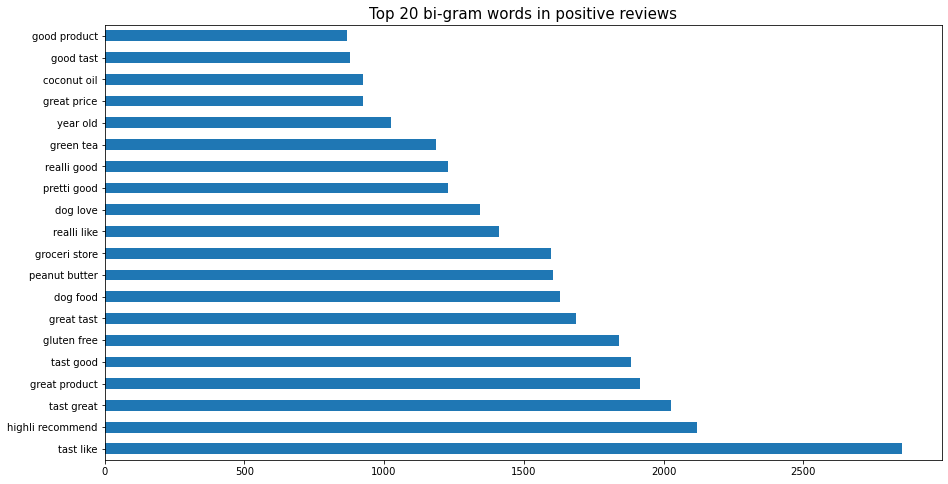

In [62]:
cvec = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=2000)
df = pd.DataFrame(cvec.fit_transform(B).toarray(), columns=cvec.get_feature_names())
df.sum(axis=0).sort_values(ascending=False).head(20).plot.barh(figsize=(15,8))
plt.title('Top 20 bi-gram words in positive reviews', fontsize=15);

Top words were 'tast like', 'highli recommend' and 'tast great' which were all optimistic words.

In [63]:
train[(train['label']==0) & (train['merge_processed'].str.contains("tast like"))][['merge_processed', 'label']].head()

,merge_processed,label
55596,tell differ oreo golden tast like oreo golden cooki love vanilla sandwich cooki look healthier choic organ cooki perfect solut healthier cooki unnam ingredi delici,0
43026,perfect exactli sister look forev tast like name brand cereal marshmallow order individu size bag tast test order larger qti plan know perfect,0
5871,yum bar delici realli recommend heat suggest packag tast like warm banana bread straight oven yum wait eat nice hot breakfast cold winter morn,0
21375,much cocont flavor purchas emuls decid reorder amazon emuls amaz use frost well homemad whip cream good let smell fool ye agre previou review said smell slightli like pina colada tast like pineappl husband start use smoothi reason reorder highli recommend product,0
83978,never go back tradit peanut butter pb recommend weight watcher leader order pack love much alreadi order pound tradit varieti even husband bare toler peanut butter like pb say tast like peanut tradit peanut butter think right chocol varieti origin describ similar nutella unfortun think slightli sweeter vagu chocolatey version origin pb good never satisfi nutella overal love varieti pb best mix ingredi like pbj sandwich bake good favorit use put tablespoon berri smoothi add protein make tast like pbj tri eat pb solo spoon might disappoint lack bit rich make peanut butter addict lastli stuff pricier regular peanut butter especi consid powder fluffi lose volum mix water think well worth cost,0


In [84]:
# an example
train.loc[5871]['merge']

"Yum! These bars are so delicious! I really recommend heating them up, as suggested on the packaging. It tastes like warm banana bread straight out of the oven! Yum! I can't wait to eat these as a nice hot breakfast on a cold winter morning."

Similarly, 'tast like' was used to compare food items that customer previously encountered as a gauge of how well the product was.

In [64]:
train[(train['label']==0) & (train['merge_processed'].str.contains("highli recommend"))][['merge_processed', 'label']].head()

,merge_processed,label
60833,quick simpl sour someon develop starter learn patienc failur worri within hour starter bubbl away strong sour nose time began also start commerci dri starter day away readi start wait week starter highli recommend live one,0
81364,best cat food avail ton research cat food would best option cat lose cat liver kidney failur think happen due taint pet food want better surviv cat main problem good brand can plant poor qualiti product merrick facil use human grade food ingredi highli recommend varieti pack start cat food patient switch cat similar take child eaten noth fast food transit healthi meal sure break solid food thoroughli mix well broth still uninterest tri mix small amount regular food took day realli got tast want eat old food still taper gradual go favorit flavor old food popular flavor merrick cowboy cuisin new england boil recommend start flavor awar may see cook blood vessel one beef look almost like pasta good thing show food made whole cut beef meat sludg,0
90291,expens oh good got dairi allergi mom gluten free grandma dairi gluten free alway look someth good cooki addict small side fairli expens gluten diari free food incred good made date past tast sweeten juic concentr lower sugar fiber oh chocolati hit spot highli recommend,0
43033,tast great gener care much healthi altern especi come coffe howev tri truvia hotel hook usual get groceri store good see avail amazon prime might get onlin instead sweeten tast realli good addit coffe dessert tast great think even tast better sugar definit tast better splenda cannot comment health aspect relat artifici sweeten sure plenti inform avail internet relat casual coffe drinker highli recommend truvia howev may better purchas larger box count instead pack six unless realli like size count box never tri definit purchas smaller box tri first,0
83458,delici mildli stimul tea arriv promptli obvious hand fill plastic bag aluminum foil wrap around nice handwritten note seller tea form super fine talcum like green powder tast great much like green tea receiv good sushi restaur better opinon great hot also fine ice cold bother bag pinch near boil water littl goe long way ounc exampl last week longer stimul smoothli even smoother strong coffe normal tea say never felt jumpi wire drink tea even sever cup done sever time cool winter day notic feel sooth aromat tea experi find best drink within hour want go bed howev plan buy fresh delici tea would recommend anyon interest tri particularli enjoy tast green tea five star highli recommend,0


In [85]:
# an example
train.loc[90291]['merge']

"Expensive BUT OH SO GOOD. I've got a dairy allergy, my mom is gluten free, and my grandma is dairy and gluten free. We're always on the look out for something good. And these are it! This cookies are addicting! They're on the small side and fairly expensive, but so is most gluten and diary free food. They're incredibly good for you, made with date paste (which you can't taste), and sweetened with juice concentrates. Lower in sugar, and they have fiber! But they're oh so chocolaty and hit the spot. I highly recommend."

Customers use 'highli recommend', aim to influence potential buyers on deciding whether they should try the products out.

In [65]:
train[(train['label']==0) & (train['merge_processed'].str.contains("tast great"))][['merge_processed', 'label']].head()

,merge_processed,label
70532,work well cough drop tast great excel drop sooth realli good flavor could eat day even without cough remind kind candi use get corner store child,0
43033,tast great gener care much healthi altern especi come coffe howev tri truvia hotel hook usual get groceri store good see avail amazon prime might get onlin instead sweeten tast realli good addit coffe dessert tast great think even tast better sugar definit tast better splenda cannot comment health aspect relat artifici sweeten sure plenti inform avail internet relat casual coffe drinker highli recommend truvia howev may better purchas larger box count instead pack six unless realli like size count box never tri definit purchas smaller box tri first,0
29347,work diet recent start diet decid buy gummi bear cannot salti meal without someth sweet afterward like fact gummi bear fat free even though serv gram carb could eat satisfi bear bigger regular one friend said lot bigger use also flavor one flavor like one yellow one might banana rest tast great two bag last month multipl peopl eat everi day end semest start give away still half bag eat work diet lost lot weight even though ate gummi everi day perfect,0
83458,delici mildli stimul tea arriv promptli obvious hand fill plastic bag aluminum foil wrap around nice handwritten note seller tea form super fine talcum like green powder tast great much like green tea receiv good sushi restaur better opinon great hot also fine ice cold bother bag pinch near boil water littl goe long way ounc exampl last week longer stimul smoothli even smoother strong coffe normal tea say never felt jumpi wire drink tea even sever cup done sever time cool winter day notic feel sooth aromat tea experi find best drink within hour want go bed howev plan buy fresh delici tea would recommend anyon interest tri particularli enjoy tast green tea five star highli recommend,0
69841,fast easi make even tast pretti good use buy local retail sadli although still carri brand stop get banana nut flavor kept get lemon bar pecan someth flavor bought brand avail tast good textur ideal either glad amazon krusteaz banana nut flavor muffin moist soggi fluffi enough dri need add cup water cup oil egg usual cook cupcak pan cupcak paper instead degre f like box say put minut come perfect busi tire bake banana nut muffin bread scratch mix conveni tast great,0


In [86]:
# an example
train.loc[70532]['merge']

'Works well as a cough drop, and tastes great! These are excellent drops. Very soothing and a really good flavor. I could eat them all day even without having a cough! Reminds me of the kind of candy I used to get in the corner stores when I was a child.'

'Tast great' was used to compliment a product

## Save to csv

In [66]:
train.shape

(79999, 17)

In [67]:
test.shape

(20000, 17)

In [68]:
train[['merge_processed', 'merge', 'score', 'label']].to_csv('../datasets/train_stem.csv', index=False)
test[['merge_processed', 'merge', 'score', 'label']].to_csv('../datasets/test_stem.csv', index=False)

## Benchmark model
### Valence Aware Dictionary for Sentiment Reasoning (VADER)
A popular rule-based sentiment analyzer, trained with NLTK lexicon to predict the polarity and intensity of emotion from text.

As vader is does not require pre-processing, we will plug in the raw dataset.

In [100]:
analyzer = SentimentIntensityAnalyzer()

In [109]:
# A negative review example
train.loc[44619]['merge']

'Deceiving size I expected the size of the lifesavers to be the size of the normal sized ones. They are very small and thin. No where in the description does it mention mini size life savers. I noticed it on the bottle when they arrived. Very disappointed.'

In [110]:
# generate polarity score for the above example
analyzer.polarity_scores(train.loc[44619]['merge'])

{'neg': 0.154, 'neu': 0.846, 'pos': 0.0, 'compound': -0.7902}

For the above sentence, VADER's sentiment intensity analyser will return a dictionary of scores for 4 categories:
- Negative
- Neutral
- Positive
- Compound

Compound is computed by normalizing the scores and is the aggregate. It ranges from -1(most extreme negative) and +1 (most extreme positive). The closer it is to +1, the higher the positivity of the text.

In [111]:
# calculate the polarity scores for each review
list = []
for reviews in train['merge']:
    d = {}
    d['neg'] = analyzer.polarity_scores(reviews)['neg'] 
    d['neu'] = analyzer.polarity_scores(reviews)['neu'] 
    d['pos'] = analyzer.polarity_scores(reviews)['pos'] 
    d['comp'] = analyzer.polarity_scores(reviews)['compound'] 
    list.append(d)

In [119]:
# reset train indext to match new dataframe
train.reset_index(drop=True, inplace=True)

In [120]:
# create a df of polarity scores with the reviews and labels
vader = pd.DataFrame(list)
vader['reviews'] = train['merge']
vader['label'] = train['label']

In [130]:
vader.head()

,neg,neu,pos,comp,reviews,label,pred
0,0.000,0.585,0.415,0.9259,"Pretty Good Thumbs up!<br /><br />Banana Nut Bread is good, if you love banana bread this soft bake bar is up your ally.",0,0
1,0.000,0.684,0.316,0.9677,Tasty This is a tasty flavor but not one I could drink everyday. The honey flavor makes it a little sweet for my palette but for a dessert coffee it works wonderfully. I won't but this for everyday repeated use but it is a good special treat flavor.,0,0
2,0.063,0.812,0.125,0.6625,"Quick simple and sour As someone who develops his own starters I have learned about patience and failure. No such worries here within 24 hours starter was bubbling away with a strong sour nose to it. At the same time as I began this I also started 2 other ""commercial"" dried starters. Both are days away from being ready. If just starting out or can't wait a week for a starter I highly recommend this live one.",0,0
3,0.109,0.629,0.262,0.7626,"best taste Taste excellent with mix berries and almond milk don't forget the ice, also try the peaches and cream I've lost 20 pounds with this powder shake.",0,0
4,0.063,0.937,0.000,-0.5106,"Bland tasting I bought these to try as a lower fat alternative to peanuts. I found the taste to be bland and chalky. What it does have going for it: it's an organic product, and the pre-portioned one ounce bags are convenient to carry in a purse or bag. It's high in protein and low in fat. I couldn't really taste the sea salt flavor though.",1,1


In [128]:
# add a column of predicted label based on compound score
vader['pred'] = vader['comp'].map(lambda x: 0 if x >= 0 else 1)

In [138]:
# number of misclassification
vader[vader['pred'] != vader['label']].shape

(18530, 7)

In [140]:
# false positive (predicted as negative sentiment when it is actually positive)
vader[(vader['label']==0) & (vader['pred']==1)].head()

,neg,neu,pos,comp,reviews,label,pred
54,0.174,0.734,0.092,-0.8103,"Don't use on hardwood floors Our corgi really loved this food toy/game.<br /><br />The only problem, we have hardwood floors and the toy was going to destroy our floors. So we're pretty bummed, but the dog won't be using this after just one day. Hardwood floors are too expensive to ruin for this toy. If you have wall to wall carpet or another type of flooring that a hard object won't damage it's great!",0,1
94,0.293,0.471,0.236,-0.2965,"Super fresh! No one likes stale Nerds! I ordered these hoping it they wouldn't be, and they.......wait for it...WEREN'T! WOOT! be confident, order these today",0,1
232,0.132,0.770,0.098,-0.7533,"Review ICV K1V-1116<br />Saccharomyces cerevisiae<br /><br />Origin<br />Selected by the Institut coop&eacute;ratif du vin in Montpellier among numerous killer strains isolated and studied by Pierre Barre at INRA, the K1V-1116 strain was the first competitive factor yeast to go into commercial production and has become one of the most widely used active dried wine yeasts in the world.<br /><br />Oenological properties and applications<br />The K1V-1116 strain is a rapid starter with a constant and complete fermentation between 10° and 35°C (50° and 95°F), capable of surviving a number of difficult conditions, such as low nutrient musts and high levels of sulfur dioxide (SO2) or sugar. Wines fermented with the K1V-1116 have very low volatile acidity, hydrogen sulfide (H2S) and foam production.<br /><br />The K1V-1116 strain tends to express the freshness of white grape varieties such as Sauvignon Blanc, Chenin Blanc and Seyval. The natural fresh fruit aromas are retained longer than with other standard yeast strains. Fruit wines and wines made from concentrates poor in nutrient balance benefit from the capacity of K1V-1116 to adapt to difficult fermentation conditions. Restarts stuck fermentations.<br /><br />Highly recommended for dry whites, aged reds, and late harvest wines.",0,1
468,0.171,0.707,0.122,-0.4174,"It really is as good as they say it is! This flour makes dough that is so easy to form into a thin, flat pizza that it makes me cry that I've wasted years struggling with dough made from King Arthur's bread flour. What difference!",0,1
543,0.057,0.914,0.029,-0.3769,My Every Day Breakfast I have an obsession with Udi's Cranberry Granola. So much so that I have Amazon deliver it to my house in 6 packs every month! I literally eat this every morning for breakfast. Some people look forward to their morning cup of coffee...I look forward to my morning bowl of Udi's!!,0,1


It predicted negative as maybe it focused on exclamation marks, words like "don't", "wont't", "wasted" or words that are used during negative feedbacks.

In [141]:
# false negative (predicted as positive sentiment when it is actually negative)
vader[(vader['label']==1) & (vader['pred']==0)].head()

,neg,neu,pos,comp,reviews,label,pred
5,0.000,0.893,0.107,0.5719,"NOT metallic There is nothing metallic about this color. It is gold in the fact that it is yellow, but that is it. There isn't any sheen or sparkle. I was bummed.",1,0
6,0.013,0.919,0.068,0.6407,"Contains Palm Fruit Oil ! Please do not buy into this product being a pure back-to-nature good for you...good for the environment product. IT IS NOT. It contains palm fruit oil. Cutting down of these forests could spell the complete demise of the orangutans as this is their habitat. Palm fruit oil is used in soaps, cosmetics, and lots of other things - but who thought it was in this high-end peanut butter??? Amazon needs to put this information in the product listing so at least people will know what they're getting.",1,0
8,0.040,0.899,0.061,0.5744,"Tastes Like Salty Tofu, Basically I haven't had vienna sausage since childhood, and even then I only had them occasionally, at other people's houses. These were much less flavorful and much saltier than I remembered. They aren't bad; they are basically tasteless, much like tofu. I would suggest to anyone thinking about buying these to see if the company markets a low sodium version.<br /><br />The ""pink slime"" scare is a bit exaggerated in its details. Still it's unnerving. However, I had heard so many times from family friends and associates who are Native American and Chinese doctors etc. about how healthful it is to consume more than just the muscle tissue of animals, that I gave it some thought. ""Pink slime"" does not contain every type of animal part. Notably it will contain some highly beneficial parts we don't normally eat in the U.S., such as tendons and ligaments. These actually are very healthy items featured in the cuisines of a number of cultures. Not only am I unlikely to sit down to a nice bowl of Chinese beef tendons (which I don't think I could even chew up), but have you priced these products in the ethnic markets? Very expensive. So, if that's the case, and these cheapo little hotdogs offer the same thing, then maybe they warranted my reconsideration. That was my line of thought, anyway.<br /><br />So - something to consider for those who are suffering from ailments such as arthritis or other bone and joint issues. Again though - seriously - look for low salt ones if you want to try them. These are too salty. For me, since I got a lot of them with the order, I will be able to use them rather like a salty condiment added to dishes such as beans.",1,0
10,0.063,0.842,0.095,0.6304,"Beware plastic jar I purchased this item from the local health food store - and it was in a glass jar.<br />Fell in love with the flavor. But when I placed my Amazon order, I didn't bother to look<br />as to whether or not it was the same glass jar (my fault). My order came today, and<br />you guessed it, the manna was in plastic jars.<br /><br />It is the same product, but in my opinion it doesn't taste as<br />good as the coconut manna from the glass jar. I'm willing to go back to the health food<br />store and pay a little bit more, so I won't have the plastic interfering with so<br />lovely a product.",1,0
20,0.024,0.803,0.173,0.9095,"More like a side dish, Add cheese and it makes a great dip I'm someone who needs some substance to her food to consider it an entree. To me this was more like a side dish. The flavor was okay, then again I'm just not a fan of most store-bought microwavable Indian dishes. I added 3 slices of Kraft American cheese and turned this into a dip for some Tostitos Scoops. Not bad.",1,0


It predicted positive as maybe it focus on positive words like "love" and within a sentence, there were multiple polarities.

In [135]:
# classification report
print(classification_report(vader['label'], vader['pred']))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85     53188
           1       0.86      0.37      0.52     26811

    accuracy                           0.77     79999
   macro avg       0.81      0.67      0.68     79999
weighted avg       0.79      0.77      0.74     79999



In [137]:
# accuracy score
accuracy_score(vader['label'], vader['pred'])

0.7683721046513081

VADER is able to classify 77% of sentiments and 37% of negative sentiment. We will build models and see if it can outperform VADER's accuracy and recall.

In [144]:
# confusion matrix
cm = confusion_matrix(vader['label'], vader['pred'])
cm_df = pd.DataFrame(
    cm,
    columns = ['Pred Positive Sentiment', 'Pred Negative Sentiment'],
    index=['Actual Positive Sentiment', 'Actual Negative Sentiment']
)
cm_df

,Pred Positive Sentiment,Pred Negative Sentiment
Actual Positive Sentiment,51628,1560
Actual Negative Sentiment,16970,9841


Some issues that we noticed about VADER.

- Not able to capture misspellings and grammatical errors that caused the analysis to overlook words. 
- Sarcasm may be misinterpreted as well. 
- There was some turns of phrase that weren't recognized.